In [12]:
import sys
import json
import pickle
import warnings
import os.path as op
import numpy as np
import pandas as pd
from os import sep
import itertools as it
from copy import deepcopy
from utilities import files
from functools import partial
from tqdm import trange, tqdm
import matplotlib.pylab as plt
from matplotlib import ticker
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import RobustScaler
from mne import read_epochs, pick_channels
from extra.tools import many_is_in, cat, shuffle_array, shuffle_array_range, consecutive_margin_ix, dump_the_dict

In [2]:
visual_epoch_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-145/sub-145-002-visual-epo.fif"
motor_epoch_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-145/sub-145-002-motor-epo.fif"
_3SD_features = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/3SD_features.csv"
_3SD_waveforms = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/3SD_waveforms.npy"
if all([op.exists(_3SD_features), op.exists(_3SD_waveforms)]):
    waveforms = np.load(_3SD_waveforms)
    columns_dict = pd.read_csv(_3SD_features)

visual_epoch = read_epochs(visual_epoch_file, verbose=False)
motor_epoch = read_epochs(motor_epoch_file, verbose=False)
visual_epoch_times = visual_epoch.times
motor_epoch_times = motor_epoch.times
del visual_epoch
del motor_epoch

buffer = 0.125
bin_width = 0.05
baseline_range = [-0.5, -0.25]


visual_time_bins = np.arange(visual_epoch_times[0] + buffer, visual_epoch_times[-1] - buffer, bin_width)
motor_time_bins = np.arange(motor_epoch_times[0] + buffer, motor_epoch_times[-1] - buffer, bin_width)

visual_bin_ranges = list(zip(visual_time_bins[:-1], visual_time_bins[1:]))
motor_bin_ranges = list(zip(motor_time_bins[:-1], motor_time_bins[1:]))
vis_time_plot = visual_time_bins[:-1]
mot_time_plot = motor_time_bins[:-1]

In [3]:
time_bins = {
    "visual": visual_time_bins,
    "motor": motor_time_bins
}

In [57]:
# max_wvf = np.max(waveforms, axis=1)
# max_wvf_prc = [np.percentile(max_wvf, 1), np.percentile(max_wvf, 99)]
# max_wvf_map = ((max_wvf >= max_wvf_prc[0]) & (max_wvf <= max_wvf_prc[1]))
# waveforms = waveforms[max_wvf_map,:]
# columns_dict = columns_dict.loc[max_wvf_map].reset_index()

In [45]:
pc_fit_subset_map = np.random.choice(np.arange(waveforms.shape[0]), size=int(waveforms.shape[0]*0.4))
PCA_3sd = PCA(n_components=20)
PCA_3sd_scaler = RobustScaler().fit(waveforms[pc_fit_subset_map, :])
PCA_3sd.fit(PCA_3sd_scaler.transform(waveforms[pc_fit_subset_map, :]))

PCA(n_components=20)

In [146]:
with open('/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/3sd_pca.pkl', 'wb') as f:
    pickle.dump(PCA_3sd, f)
with open('/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/3sd_scaler.pkl', 'wb') as f:
    pickle.dump(PCA_3sd_scaler, f)

In [58]:
PC_3sd_scores = PCA_3sd.transform(PCA_3sd_scaler.transform(waveforms))

In [20]:
pcs = ["PC_{}".format(i+1) for i in range(PC_3sd_scores.shape[1])]

In [59]:
pc_s = pd.DataFrame.from_dict({i: PC_3sd_scores[:,ix] for ix, i in enumerate(pcs)})
output_dict = pd.concat([columns_dict, pc_s], axis=1)

In [33]:
t = np.round(time_bins["vis"], 3)

In [70]:
time_ranges = list(zip(t[:-1], t[1:]))

In [69]:
subjects = columns_dict.subject.unique()
trials = np.arange(448)

In [89]:
total_burst_rate = {}
for sub in tqdm(subjects):
    for trial_type in ["visual", "motor"]:
        subset = output_dict.loc[
            (output_dict.subject == sub) &
            (output_dict.trial_type == trial_type)
        ]
        all_tr_tc = []
        for trial in subset.pp_ix.unique():
            t = np.round(time_bins[trial_type], 3)
            t = list(zip(t[:-1], t[1:]))
            tr_tc = []
            for tb, te in t:
                out = subset.loc[
                    (subset.pp_ix == trial) &
                    (subset.peak_time >= tb) &
                    (subset.peak_time < te)
                ].polarity.count()
                tr_tc.append(out)
            all_tr_tc.append(tr_tc)
        total_burst_rate[(sub, trial_type)] = np.array(all_tr_tc)

In [147]:
with open('/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/3sd_burst_rate.pkl', 'wb') as f:
    pickle.dump(total_burst_rate, f)

In [167]:
pc_score_time = {}
for sub in tqdm(subjects):
    for trial_type in ["visual", "motor"]:
        subset = output_dict.loc[
            (output_dict.subject == sub) &
            (output_dict.trial_type == trial_type)
        ]
        for pc in pcs:
            all_tr_tc = []
            for trial in subset.pp_ix.unique():
                t = np.round(time_bins[trial_type], 3)
                t = list(zip(t[:-1], t[1:]))
                tr_tc = []
                for tb, te in t:              
                    out = subset.loc[
                        (subset.pp_ix == trial) &
                        (subset.peak_time >= tb) &
                        (subset.peak_time < te)
                    ][pc].mean()
                    tr_tc.append(out)
                all_tr_tc.append(tr_tc)
            pc_score_time[(sub, trial_type, pc)] = np.array(all_tr_tc)
with open('/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/3sd_pc_score_in_time.pkl', 'wb') as f:
    pickle.dump(pc_score_time, f)

100%|████████████████████████████████████████| 37/37 [5:50:33<00:00, 568.48s/it]


In [ ]:
pc_score_time = {}
for sub in tqdm(subjects):
    for trial_type in ["visual", "motor"]:
        subset = output_dict.loc[
            (output_dict.subject == sub) &
            (output_dict.trial_type == trial_type)
        ]
        for pc in pcs:
            all_tr_tc = []
            for trial in subset.pp_ix.unique():
                t = np.round(time_bins[trial_type], 3)
                t = list(zip(t[:-1], t[1:]))
                tr_tc = []
                for tb, te in t:              
                    out = subset.loc[
                        (subset.pp_ix == trial) &
                        (subset.peak_time >= tb) &
                        (subset.peak_time < te)
                    ][pc].mean()
                    tr_tc.append(out)
                all_tr_tc.append(tr_tc)
            pc_score_time[(sub, trial_type, pc)] = np.array(all_tr_tc)
with open('/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/3sd_pc_score_in_time.pkl', 'wb') as f:
    pickle.dump(pc_score_time, f)

In [124]:
bl_ix = np.where(
    (time_bins["visual"] >= baseline_range[0]) &
    (time_bins["visual"] <= baseline_range[-1])
)[0]

mean_burst_rate = {}
mean_burst_rate["visual"] = np.array([total_burst_rate[(sub, "visual")].mean(axis=0) for sub in subjects]) / bin_width
mean_burst_rate["motor"] = np.array([total_burst_rate[(sub, "motor")].mean(axis=0) for sub in subjects]) / bin_width
mean_burst_rate["baseline"] = mean_burst_rate["visual"][:,bl_ix].mean(axis=1).reshape(-1,1)
mean_burst_rate["visual_baselined"] = (mean_burst_rate["visual"] - mean_burst_rate["baseline"]) / mean_burst_rate["baseline"]
mean_burst_rate["motor_baselined"] = (mean_burst_rate["motor"] - mean_burst_rate["baseline"]) / mean_burst_rate["baseline"]

(-0.65, 0.25)

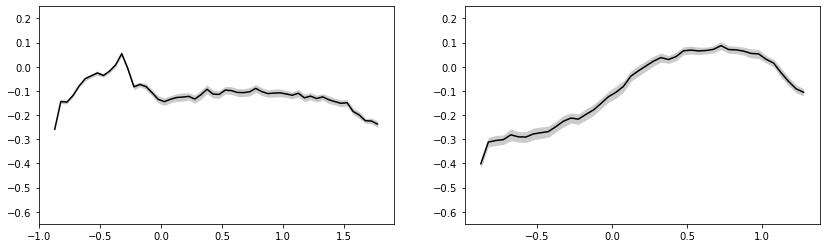

In [143]:
f, ax = plt.subplots(1,2, figsize=[14,4], facecolor="white")
ax[0].plot(vis_time_plot, mean_burst_rate["visual_baselined"].mean(axis=0), lw=1.5, c="black")
ax[0].fill_between(
    vis_time_plot,
    mean_burst_rate["visual_baselined"].mean(axis=0) - mean_burst_rate["visual_baselined"].std(axis=0) / np.sqrt(37),
    mean_burst_rate["visual_baselined"].mean(axis=0) + mean_burst_rate["visual_baselined"].std(axis=0) / np.sqrt(37),
    lw=0, color="black", alpha=0.2
)
ax[1].plot(mot_time_plot, mean_burst_rate["motor_baselined"].mean(axis=0), lw=1.5, c="black")
ax[1].fill_between(
    mot_time_plot,
    mean_burst_rate["motor_baselined"].mean(axis=0) - mean_burst_rate["motor_baselined"].std(axis=0) / np.sqrt(37),
    mean_burst_rate["motor_baselined"].mean(axis=0) + mean_burst_rate["motor_baselined"].std(axis=0) / np.sqrt(37),
    lw=0, color="black", alpha=0.2
)

ax[0].set_ylim(-0.65, 0.25)
ax[1].set_ylim(-0.65, 0.25)

In [136]:
mean_burst_rate["visual_baselined"].std(axis=0) / np.sqrt(37)

array([0.00639218, 0.00785686, 0.00761834, 0.00682395, 0.00578409,
       0.00880353, 0.00759707, 0.00879505, 0.0076425 , 0.00744299,
       0.00811425, 0.00971049, 0.00889504, 0.01207236, 0.00907965,
       0.01307933, 0.0134601 , 0.01501728, 0.01593904, 0.01478722,
       0.01592973, 0.01766867, 0.01459346, 0.01676152, 0.01890966,
       0.018392  , 0.0165116 , 0.01559149, 0.01535901, 0.01626923,
       0.01632686, 0.01625326, 0.01743542, 0.01589544, 0.01662237,
       0.01506309, 0.01674532, 0.01600873, 0.01460071, 0.01425838,
       0.01553796, 0.01551134, 0.01512677, 0.01435204, 0.01351901,
       0.01564392, 0.01445464, 0.01460289, 0.01365907, 0.0139472 ,
       0.01423132, 0.01025581, 0.01234924, 0.01320526])

In [6]:
path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/3SD_features.csv"
burst_features = pd.read_csv(path)

In [7]:
burst_features.columns

Index(['index', 'trial', 'peak_freq', 'peak_amp_iter', 'peak_amp_base',
       'peak_time', 'peak_adjustment', 'fwhm_freq', 'fwhm_time', 'polarity',
       'block', 'pp_ix', 'subject', 'sensor', 'trial_type', 'PC_1', 'PC_2',
       'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10',
       'PC_11', 'PC_12', 'PC_13', 'PC_14', 'PC_15', 'PC_16', 'PC_17', 'PC_18',
       'PC_19', 'PC_20'],
      dtype='object')

In [13]:
def do_trials(data_snippet, pc_key, score_range, tr_ix):
    peak_times = data_snippet.loc[
        (data_snippet.pp_ix == tr_ix)
    ].peak_time.to_numpy()
    pc_scores = data_snippet.loc[
        (data_snippet.pp_ix == tr_ix)
    ][pc_key].to_numpy()

    PC_br, t_bin, m_bin = np.histogram2d(
        peak_times,
        pc_scores,
        bins = [time_bins[ep], score_range]
    )
    PC_br = PC_br / bin_width
    PC_br = gaussian_filter(PC_br, [1,1])
    PC_br_all_trials[tr_ix] = PC_br

PC_to_analyse = ["PC_{}".format(i) for i in range(1,21)]

PC_burst_rate_spec_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/3sd_PC_burst_rate_spec.pkl"
if op.exists(PC_burst_rate_spec_file):
    PC_burst_rate_spec = pickle.load(open(PC_burst_rate_spec_file, "rb"))

else:
    PC_burst_rate_spec = {i: {"visual": [], "motor": []} for i in PC_to_analyse}

    subjects = burst_features.subject.unique()

    for pc_key in tqdm(PC_to_analyse, colour="green"):
        for sub in tqdm(subjects, colour="purple"):
            sub_PC_br = {
                "visual": [],
                "motor": []
            }
            comp_score_all = burst_features.loc[
                (burst_features.subject == sub)
            ][pc_key]
            lower_bound = np.percentile(comp_score_all, 1)
            upper_bound = np.percentile(comp_score_all, 99)
            score_range = np.linspace(lower_bound, upper_bound, num=41)
            for ep in ["visual", "motor"]:
                data_snippet = burst_features.loc[
                    (burst_features.subject == sub) &
                    (burst_features.trial_type == ep) &
                    (burst_features[pc_key] >= lower_bound) &
                    (burst_features[pc_key] <= upper_bound)
                ][["peak_time", pc_key, "pp_ix"]]
                
                tr_uniq_ix = data_snippet.pp_ix.unique()
                
                PC_br_all_trials = {}
                
                Parallel(n_jobs=10, require="sharedmem")(delayed(do_trials)(
                    data_snippet, pc_key, score_range, tr_ix
                ) for tr_ix in tr_uniq_ix);
                
                PC_br_all_trials = [PC_br_all_trials[i] for i in PC_br_all_trials.keys()]
                PC_br_all_trials = np.mean(PC_br_all_trials, axis=0)
                sub_PC_br[ep] = PC_br_all_trials

            # baselining
            bl_ix = np.where(
                (time_bins["visual"] >= baseline_range[0]) &
                (time_bins["visual"] <= baseline_range[-1])
            )[0]
            baseline = np.mean(sub_PC_br["visual"][bl_ix,:], axis=0).reshape(1, -1)
            sub_PC_br["visual"] = (sub_PC_br["visual"] - baseline) / baseline
            sub_PC_br["motor"] = (sub_PC_br["motor"] - baseline) / baseline

            for ep in ["visual", "motor"]:
                PC_burst_rate_spec[pc_key][ep].append(sub_PC_br[ep])
    pickle.dump(PC_burst_rate_spec, open(PC_burst_rate_spec_file, "wb"))

 46%|███████████████████▊                       | 17/37 [01:03<01:14,  3.72s/it]


 97%|█████████████████████████████████████████▊ | 36/37 [02:09<00:03,  3.79s/it]


 43%|██████████████████▌                        | 16/37 [01:00<01:15,  3.61s/it]


 95%|████████████████████████████████████████▋  | 35/37 [02:11<00:07,  3.80s/it]


 41%|█████████████████▍                         | 15/37 [00:56<01:22,  3.77s/it]


 92%|███████████████████████████████████████▌   | 34/37 [01:59<00:11,  3.72s/it]


 38%|████████████████▎                          | 14/37 [00:51<01:24,  3.69s/it]


 89%|██████████████████████████████████████▎    | 33/37 [02:02<00:14,  3.71s/it]


100%|██████████████████████████████████████████| 20/20 [45:25<00:00, 136.25s/it]


In [10]:
PC_to_analyse

['PC_1',
 'PC_2',
 'PC_3',
 'PC_4',
 'PC_5',
 'PC_6',
 'PC_7',
 'PC_8',
 'PC_9',
 'PC_10',
 'PC_11',
 'PC_12',
 'PC_13',
 'PC_14',
 'PC_15',
 'PC_16',
 'PC_17',
 'PC_18',
 'PC_19',
 'PC_20']